In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

warnings.filterwarnings("ignore")


df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

# sss = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

# for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
#     original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
#     original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
Xtrain = original_Xtrain.values
Xtest = original_Xtest.values
ytrain = original_ytrain.values
ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print('Normal         Abnormal')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

Normal         Abnormal
[0.99827075 0.00172925]
[0.99827955 0.00172045]


In [3]:
input_layer = Input(shape=(X.values.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [4]:
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

In [5]:
autoencoder.compile(optimizer="adam", loss="mse",metrics=['accuracy'])

In [6]:
x_scale = preprocessing.MinMaxScaler().fit_transform(original_Xtrain)
auto_x_norm , auto_x_fraud = x_scale[original_ytrain== 0], x_scale[original_ytrain ==1]

In [7]:
auto_x_norm.shape

(227451, 30)

In [8]:
auto_history = autoencoder.fit(auto_x_norm, auto_x_norm, batch_size=256, epochs=50, shuffle=True, validation_split=0.2,verbose=1).history

Epoch 1/50
711/711 [==============================] - 2s 2ms/step - loss: 0.0709 - accuracy: 0.6303 - val_loss: 0.0357 - val_accuracy: 0.8278
Epoch 2/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0355 - accuracy: 0.8635 - val_loss: 0.0353 - val_accuracy: 0.9526
Epoch 3/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0353 - accuracy: 0.9582 - val_loss: 0.0353 - val_accuracy: 0.9670
Epoch 4/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0350 - accuracy: 0.9654 - val_loss: 0.0314 - val_accuracy: 0.9116
Epoch 5/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0314 - accuracy: 0.9378 - val_loss: 0.0314 - val_accuracy: 0.9775
Epoch 6/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0314 - accuracy: 0.9752 - val_loss: 0.0314 - val_accuracy: 0.9438
Epoch 7/50
711/711 [==============================] - 1s 1ms/step - loss: 0.0314 - accuracy: 0.9761 - val_loss: 0.0313 - val_accuracy: 0.9868
Epoch 

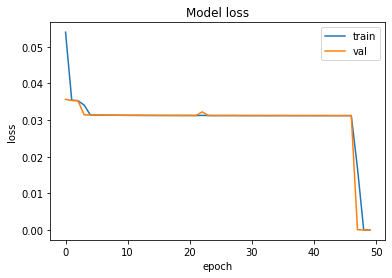

In [9]:
plt.plot(auto_history['loss'])
plt.plot(auto_history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])

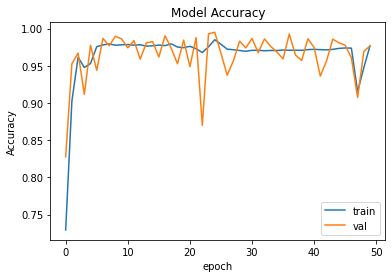

In [10]:
plt.plot(auto_history['accuracy'])
plt.plot(auto_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])

In [11]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))

    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.show()

In [12]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix,classification_report

Xtest_scale = preprocessing.MinMaxScaler().fit_transform(original_Xtest)
auto_pred = autoencoder.predict(Xtest_scale)
auto_pred

array([[0.4137431 , 0.5255004 , 0.9517639 , ..., 0.41318703, 0.36794305,
        0.33085978],
       [0.24234208, 0.79450804, 0.490156  , ..., 0.3019799 , 0.30902848,
        0.14655116],
       [0.18069854, 0.79778206, 0.5319645 , ..., 0.3039441 , 0.29797113,
        0.07784523],
       ...,
       [0.7671333 , 0.7870159 , 0.50622874, ..., 0.3310328 , 0.31825158,
        0.08207313],
       [0.2911954 , 0.76481104, 0.5094752 , ..., 0.32157668, 0.29470453,
        0.11953075],
       [0.25614384, 0.71232706, 0.4930327 , ..., 0.29860598, 0.27606094,
        0.16617835]], dtype=float32)

In [84]:
mse = np.mean(np.power(Xtest_scale - auto_pred,2),axis=1)
print('Threshold: ',np.quantile(mse,0.6))
threshold =np.quantile(mse,0.6)

Threshold:  0.01592922198219624


In [85]:
original_Xtest_df = pd.DataFrame(original_Xtest,columns=X.columns)
original_Xtest_df['MSE'] = mse 
original_Xtest_df['Mse_outlier'] = 0
original_Xtest_df.loc[original_Xtest_df['MSE'] > threshold,'Mse_outlier'] = 1
original_Xtest_df['Class'] = original_ytest
original_Xtest_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,MSE,Mse_outlier,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,0.026266,1,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0.015493,0,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0.015876,0,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0.015165,0,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0.013998,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75723,56223.0,-1.994348,1.503076,-0.365560,0.780223,-0.957956,0.038648,-0.453702,1.553565,-0.561964,...,-0.081356,-0.366704,-0.269380,-0.278170,0.082042,-0.015071,75.69,0.016540,1,0
252263,155726.0,-0.234567,0.733694,0.486250,-0.718186,0.782227,-0.788837,1.056307,-0.175016,-0.244864,...,-0.024845,-0.428558,-0.563551,0.159926,0.094924,0.163736,9.99,0.015676,0,0
221246,142491.0,0.040441,-0.109737,-1.266430,1.004783,2.223390,-0.670372,0.490662,-0.033739,-0.307052,...,0.162391,-1.180279,-1.484172,-0.619133,0.357845,0.354379,7.63,0.015890,0,0
81910,59157.0,-0.495048,0.991481,1.671584,-0.342474,0.470012,-0.348503,0.996077,-0.351891,-0.219231,...,-0.145562,-0.011279,-0.162997,0.020511,0.040529,-0.269775,3.59,0.016808,1,0


In [86]:
confusion_matrix(original_Xtest_df['Class'].values, original_Xtest_df['Mse_outlier'].values)

array([[34121, 22743],
       [   56,    42]], dtype=int64)

In [87]:
roc_auc_score(original_Xtest_df['Class'].values, original_Xtest_df['Mse_outlier'].values)

0.5143085758501488

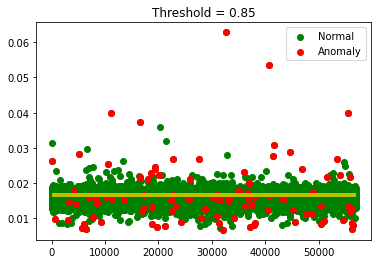

In [157]:
threshold_vis=0.15
threshold_score=mse[np.argsort(-mse)][round(threshold_vis*len(original_ytest))]
plt.scatter(range(len(mse)),mse,c='g',label='Normal')
plt.scatter(np.array(range(len(mse)))[original_ytest==1],mse[original_ytest==1],c='r',label='Anomaly')

plt.hlines(threshold_score,xmin=0,xmax=len(mse),colors='y',linewidth=4)

plt.title(f'Threshold = {1-threshold_vis}')
plt.legend()
plt.show()

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
iso=IsolationForest(n_estimators=100, max_samples= len(x_scale),contamination = 0.001727485630620034,n_jobs=5, random_state=42)
iso_history = iso.fit(x_scale)
iso_dec = iso_history.decision_function(Xtest_scale)

In [111]:
print('Threshold: ',np.quantile(1 - iso_dec,0.6))
isothreshold =np.quantile(1 - iso_dec,0.6)
iso_df = pd.DataFrame(original_Xtest,columns=X.columns)
iso_df['outlier'] = 0
iso_df["iso_dec"] = iso_dec
iso_df.loc[iso_df['iso_dec'] < (1-isothreshold),'outlier'] = 1
iso_df['Class']= original_ytest

Threshold:  1.1280946661193587


In [112]:
roc_auc_score(original_ytest,iso_df['outlier'].values)

0.7442960935077464

In [113]:
iso_cnf = confusion_matrix(original_ytest,iso_df['outlier'].values)
iso_cnf

array([[34166, 22698],
       [   11,    87]], dtype=int64)

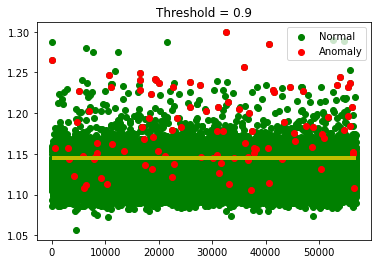

In [155]:
iso_dec = 1- iso_dec
threshold_vis=0.1
threshold_score=iso_dec[np.argsort(-iso_dec)][round(threshold_vis*len(original_ytest))]
plt.scatter(range(len(iso_dec)),iso_dec,c='g',label='Normal')
plt.scatter(np.array(range(len(iso_dec)))[original_ytest==1],iso_dec[original_ytest==1],c='r',label='Anomaly')

plt.hlines(threshold_score,xmin=0,xmax=len(iso_dec),colors='y',linewidth=4)

plt.title(f'Threshold = {1-threshold_vis}')
plt.legend()
plt.show()

In [23]:
km_model = KMeans(n_clusters=100,random_state=42,n_jobs=-1)

km_model.fit(x_scale)
km_clusters = km_model.predict(Xtest_scale)
km_clusters_centers=km_model.cluster_centers_

In [150]:
dist = [np.linalg.norm(x-y) for x,y in zip(Xtest_scale,km_clusters_centers[km_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,60)]=1
km_y_pred[dist<np.percentile(dist,60)]=0

In [151]:
roc_auc_score(original_ytest,km_y_pred)

0.7034094237019514

In [152]:
km_cnf = confusion_matrix(original_ytest,km_y_pred)
km_cnf

array([[34158, 22706],
       [   19,    79]], dtype=int64)

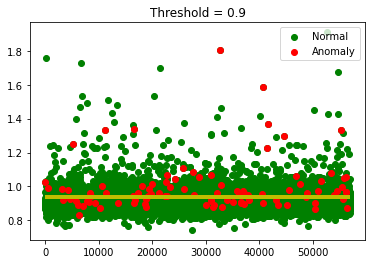

In [154]:
km_y_pred = np.array(dist)
threshold_vis=0.1
threshold_score=km_y_pred[np.argsort(-km_y_pred)][round(threshold_vis*len(original_ytest))]
plt.scatter(range(len(km_y_pred)),km_y_pred,c='g',label='Normal')
plt.scatter(np.array(range(len(km_y_pred)))[original_ytest==1],km_y_pred[original_ytest==1],c='r',label='Anomaly')

plt.hlines(threshold_score,xmin=0,xmax=len(km_y_pred),colors='y',linewidth=4)

plt.title(f'Threshold = {1-threshold_vis}')
plt.legend()
plt.show()